### RNN: economic choice FULL TRAINING

Module path status checked for: /mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules
Setup Complete.
Initializing Actor-Critic Agent structure...
Detected Obs size: 6, Act size: 3
Building agent models...
Agent models built.
Agent structure initialized.

  Starting Training Stage 1: Stage_1  
  Episodes: 450, ALR=5.0e-03, CLR=5.0e-03
  Env Params: RewardB=100, AbortP=-1.0
  Step Rewards: Fix=0.1, GoDec=0.1, GoFix=-0.1, Hold=0.5
  Load From: None
  Save To:   saved_models/stage1_high_shaping
------------------------------------------------------------
  Starting stage 1 from scratch (no weights loaded).
  Creating environment for this stage...
  Setting optimizer learning rates: Actor=5.0e-03, Critic=5.0e-03
  Starting training loop for 450 episodes...
Episode 20	Total Reward: -1.00	Actor Loss: -0.0430	Critic Loss: 0.0018
Episode 40	Total Reward: -1.00	Actor Loss: -0.1513	Critic Loss: 0.0206
Episode 60	Total Reward: -1.00	Actor Loss: -0.2344	Critic Loss: 0.02

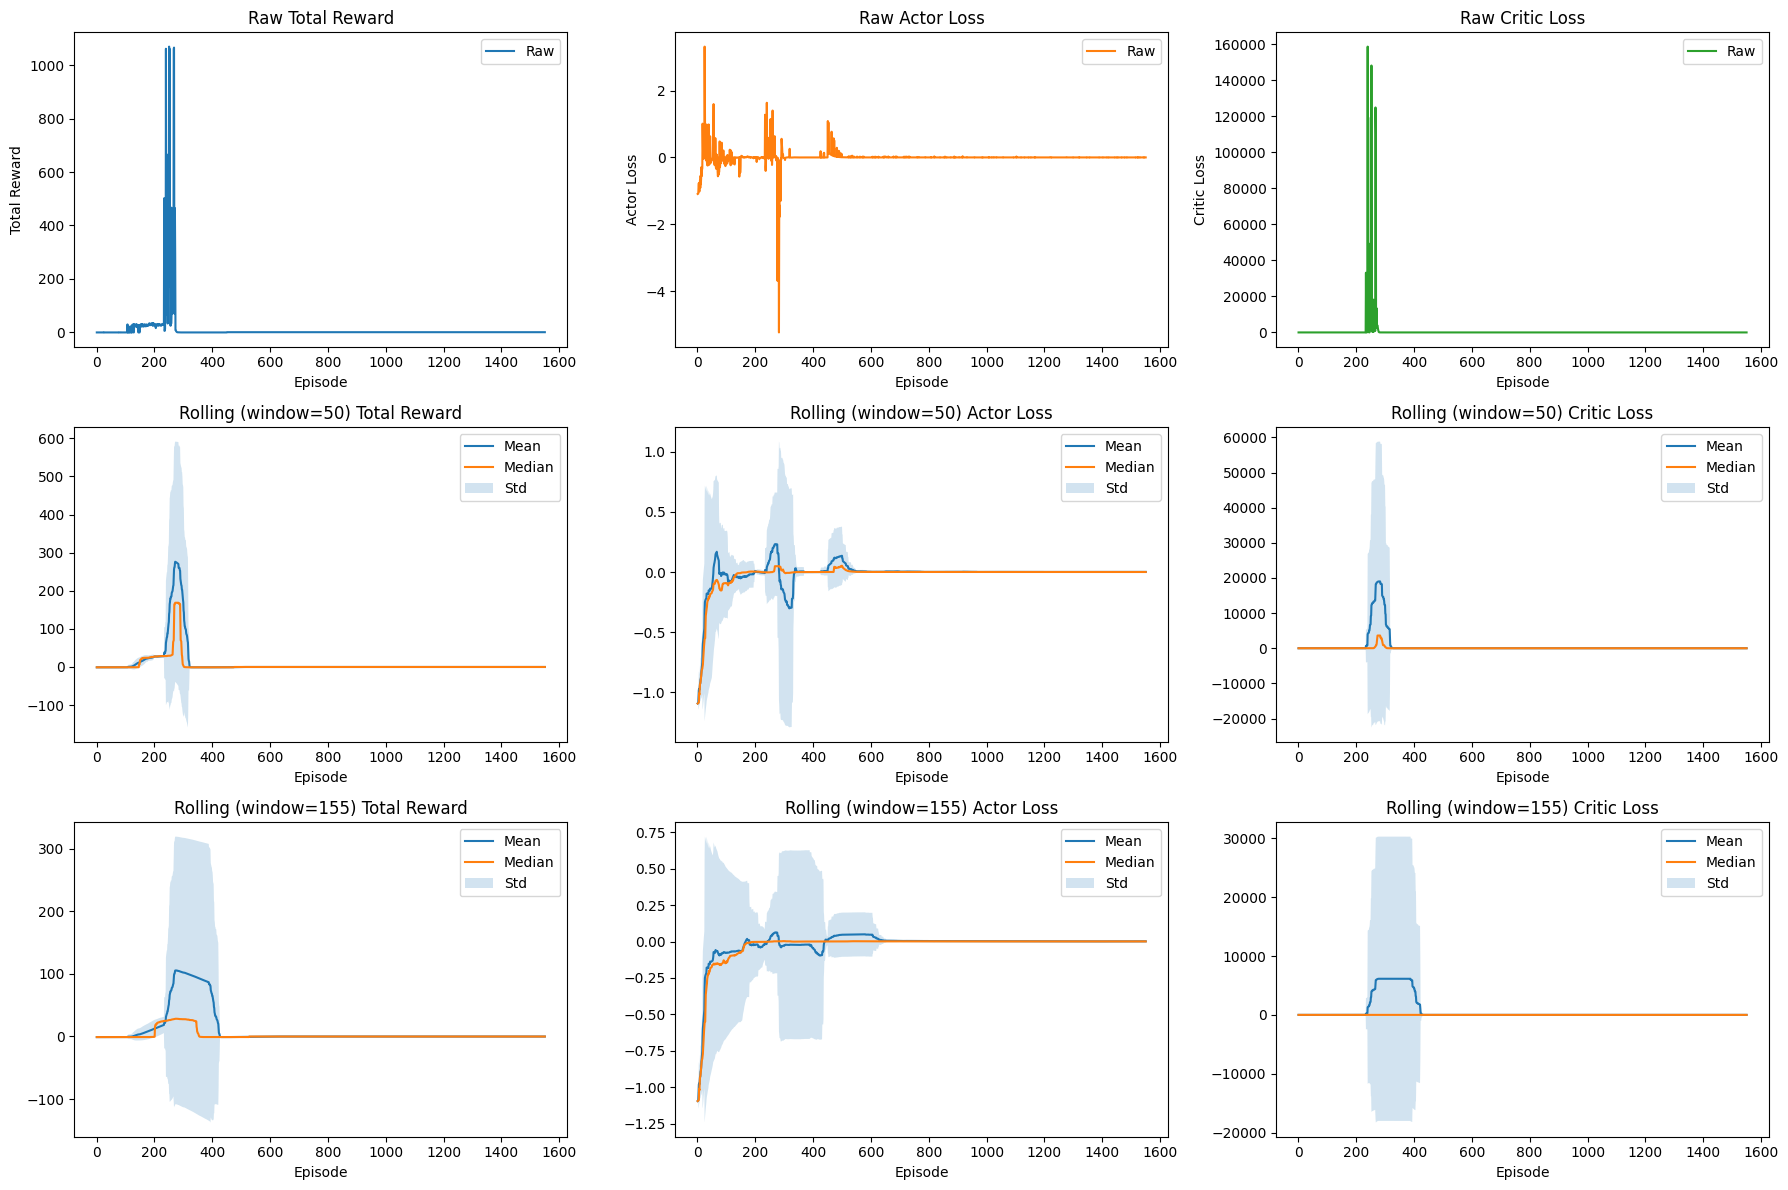

Metrics plot displayed.
Plotting neuron firing rates from the last stage...


/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:93: RuntimeWarning: Mean of empty slice
  first_episode = np.nanmean(tensor[:, :, 0], axis=0)
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:94: RuntimeWarning: Mean of empty slice
  last_episode = np.nanmean(tensor[:, :, -1], axis=0)


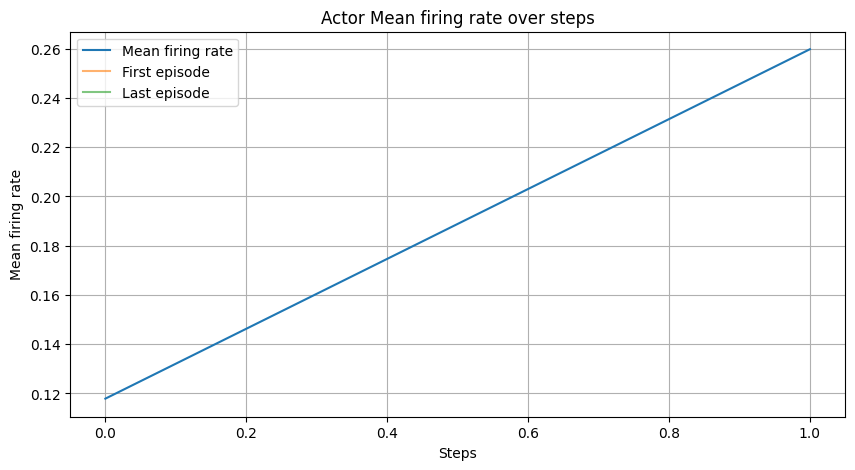

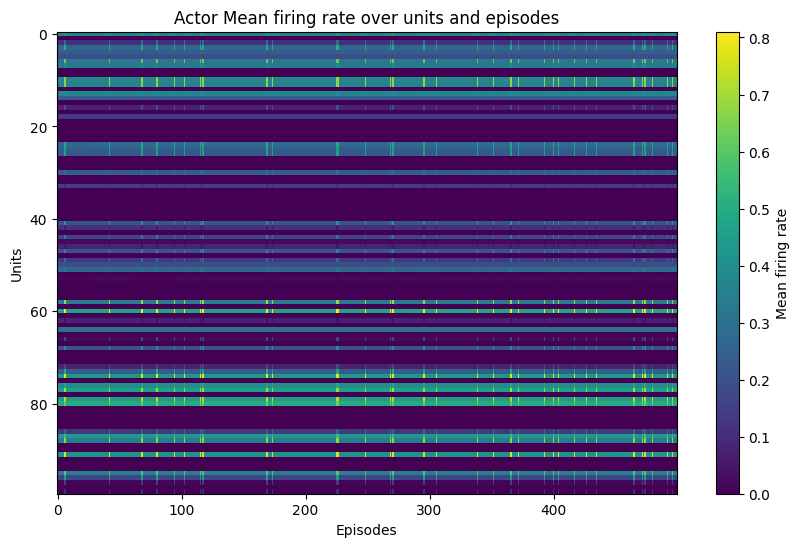

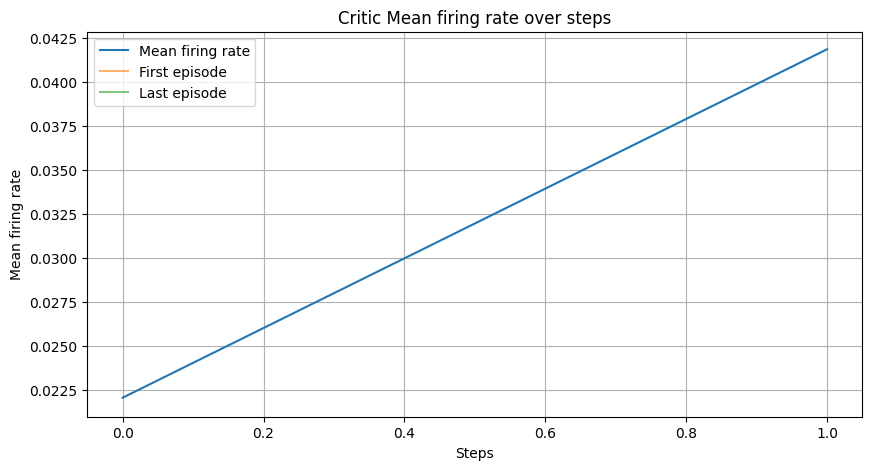

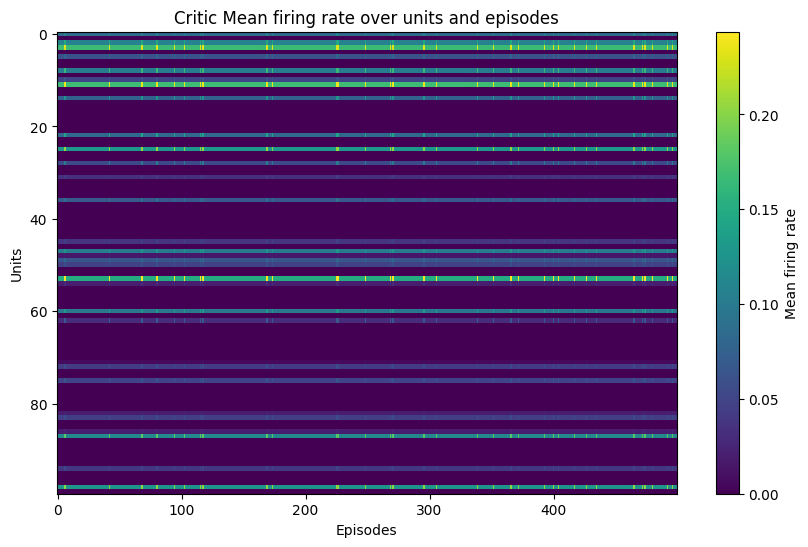

Firing rate plot displayed.

Script finished.


In [ ]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time # To time stages

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))
if module_path not in sys.path: sys.path.append(module_path)
print(f"Module path status checked for: {module_path}")

# --- Import custom modules ---
from env_economic_choice_2 import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Base Configuration ---
base_config = {
    "env_dt_ms": 10,
    "A_to_B_ratio": 2.2,
    "input_noise_sigma": 0.01,
    "gamma": 0.99,
    "l2_actor": 1e-5,
    "l2_critic": 1e-5,

    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "GRU_modified",
    "alpha": 0.1,
    "actor_prob_connection": 1.0,
    "critic_prob_connection": 1.0,

    "print_interval": 20,
    "record_history": 1
}

# --- Define Training Stages ---
training_stages = [
    {
        "stage_name": "Stage_1",
        "num_episodes": 450,
        "actor_lr": 5e-3,
        "critic_lr": 5e-3,
        # --- Env Params for this stage ---
        "reward_B": 100, 
        "abort_penalty": -1.0,
        "reward_fixation": 0.1,
        "reward_go_decision": 0.1,
        "reward_go_fixation": -0.1,
        "reward_choice_hold": 0.5,
        # --- Save/Load ---
        "load_weights_from": None,
        "save_weights_as": "saved_models/stage1_high_shaping"
    },
    {
        "stage_name": "Stage_2",
        "num_episodes": 300,
        "actor_lr": 1e-3,
        "critic_lr": 1e-3,
        # --- Env Params for this stage ---
        "reward_B": 100,
        "abort_penalty": -0.1,
        "reward_fixation": 0.01,
        "reward_go_decision": 0.01,
        "reward_go_fixation": -0.02,
        "reward_choice_hold": 0.05,
        # --- Save/Load ---
        "load_weights_from": "saved_models/stage1_high_shaping",
        "save_weights_as": "saved_models/stage2_medium_shaping"
    },
    {
        "stage_name": "Stage_3",
        "num_episodes": 300,
        "actor_lr": 5e-4,
        "critic_lr": 5e-4,
         # --- Env Params for this stage ---
        "reward_B": 1,
        "abort_penalty": -0.1,
        "reward_fixation": 0.001,
        "reward_go_decision": 0.001,
        "reward_go_fixation": -0.01,
        "reward_choice_hold": 0.01,
        # --- Save/Load ---
        "load_weights_from": "saved_models/stage2_medium_shaping",
        "save_weights_as": "saved_models/stage3_low_shaping"
    },
    {
        "stage_name": "Stage_4",
        "num_episodes": 500,
        "actor_lr": 1e-4,
        "critic_lr": 1e-4,
        # --- Env Params for this stage ---
        "reward_B": 1,
        "abort_penalty": -0.1,
        "reward_fixation": 0.0,
        "reward_go_decision": 0.0,
        "reward_go_fixation": 0.0,
        "reward_choice_hold": 0.0,
        # --- Save/Load ---
        "load_weights_from": "saved_models/stage3_low_shaping",
        "save_weights_as": "saved_models/stage4_final"
    }
]

# --- Ensure save directory exists ---
save_dir = os.path.dirname(training_stages[0]["save_weights_as"])
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")

# --- Agent Setup (Initialize ONCE) ---
print("Initializing Actor-Critic Agent structure...")
temp_env = EconomicChoiceEnv(dt=base_config["env_dt_ms"])
obs_size = temp_env.observation_space.shape[0]
act_size = temp_env.action_space.n
temp_env.close()
print(f"Detected Obs size: {obs_size}, Act size: {act_size}")

agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=base_config["actor_hidden_size"],
    critic_hidden_size=base_config["critic_hidden_size"],
    actor_layers=base_config["actor_layers"],
    critic_layers=base_config["critic_layers"],
    actor_lr=training_stages[0]['actor_lr'],
    critic_lr=training_stages[0]['critic_lr'],
    actor_prob_connection=base_config["actor_prob_connection"],
    critic_prob_connection=base_config["critic_prob_connection"],
    layer_type=base_config["layer_type"],
    alpha=base_config["alpha"]
)
# --- Build models ---
print("Building agent models...")
try:
    dummy_state = np.zeros(obs_size, dtype=np.float32)
    _ = agent.select_action(dummy_state, training=False)
    _ = agent.evaluate_state(dummy_state, training=False)
    print("Agent models built.")
except Exception as e:
    print(f"Warning: Error during dummy model call (build step): {e}")

print("Agent structure initialized.")

# --- Variables to store combined history ---
all_total_rewards = []
all_actor_losses = []
all_critic_losses = []
stage_transitions = [0]
current_total_episodes = 0
last_actor_fr = None
last_critic_fr = None

# --- Training Loop Across Stages ---
total_training_start_time = time.time()
for i, stage_config in enumerate(training_stages):
    stage_start_time = time.time()
    print("\n" + "="*60)
    print(f"  Starting Training Stage {i+1}: {stage_config['stage_name']}  ")
    print("="*60)
    # --- Print Stage Config ---
    print(f"  Episodes: {stage_config['num_episodes']}, ALR={stage_config['actor_lr']:.1e}, CLR={stage_config['critic_lr']:.1e}")
    print(f"  Env Params: RewardB={stage_config['reward_B']}, AbortP={stage_config['abort_penalty']}") # Added Env Params
    print(f"  Step Rewards: Fix={stage_config['reward_fixation']}, GoDec={stage_config['reward_go_decision']}, GoFix={stage_config['reward_go_fixation']}, Hold={stage_config['reward_choice_hold']}")
    print(f"  Load From: {stage_config['load_weights_from']}")
    print(f"  Save To:   {stage_config['save_weights_as']}")
    print("-"*60)

    # 1. Load Weights for the agent (if specified)
    if stage_config['load_weights_from']:
        print(f"  Attempting to load weights from: {stage_config['load_weights_from']}")
        load_successful = agent.load_weights(stage_config['load_weights_from'])
        if not load_successful:
            print(f"  WARNING: Failed to load weights for stage {i+1}. Continuing with current agent weights.")
    else:
        print("  Starting stage 1 from scratch (no weights loaded).")

    # 2. Create Environment with stage-specific parameters
    print("  Creating environment for this stage...")
    env = EconomicChoiceEnv(
        # Base params
        dt=base_config["env_dt_ms"],
        A_to_B_ratio=base_config["A_to_B_ratio"],
        input_noise_sigma=base_config["input_noise_sigma"],
        # Stage-specific params
        reward_B=stage_config["reward_B"],
        abort_penalty=stage_config["abort_penalty"],
        reward_fixation=stage_config["reward_fixation"],
        reward_go_decision=stage_config["reward_go_decision"],
        reward_go_fixation=stage_config["reward_go_fixation"],
        reward_choice_hold=stage_config["reward_choice_hold"]
    )
    env.reset(seed=seed_value + i)

    # 3. Set Agent Optimizer Learning Rates for this stage
    print(f"  Setting optimizer learning rates: Actor={stage_config['actor_lr']:.1e}, Critic={stage_config['critic_lr']:.1e}")
    agent.actor_optimizer.learning_rate.assign(stage_config['actor_lr'])
    agent.critic_optimizer.learning_rate.assign(stage_config['critic_lr'])

    # 4. Train for this stage using train_agent function
    print(f"  Starting training loop for {stage_config['num_episodes']} episodes...")
    stage_rewards, stage_actor_loss, stage_critic_loss, \
    stage_actor_fr, stage_critic_fr = train_agent(
        env=env,
        agent=agent,
        num_episodes=stage_config["num_episodes"],
        gamma=base_config["gamma"],
        print_interval=base_config["print_interval"],
        l2_actor=base_config["l2_actor"],
        l2_critic=base_config["l2_critic"],
        record_history=base_config["record_history"]
    )

    # 5. Append results to overall history
    all_total_rewards.extend(stage_rewards)
    all_actor_losses.extend(stage_actor_loss)
    all_critic_losses.extend(stage_critic_loss)
    current_total_episodes += len(stage_rewards)
    stage_transitions.append(current_total_episodes)
    last_actor_fr = stage_actor_fr
    last_critic_fr = stage_critic_fr

    # 6. Save Agent Weights
    if stage_config['save_weights_as']:
        print(f"  Saving agent weights to: {stage_config['save_weights_as']}")
        agent.save_weights(stage_config['save_weights_as'])

    # 7. Close environment instance for this stage
    env.close()
    print("  Environment closed for this stage.")

    stage_duration = time.time() - stage_start_time
    print(f"--- Stage {i+1} ({stage_config['stage_name']}) finished in {stage_duration:.2f} seconds ---")


print("\n" + "="*60)
print("  All Training Stages Finished.")
total_training_duration = time.time() - total_training_start_time
print(f"  Total training duration: {total_training_duration:.2f} seconds.")
print("="*60 + "\n")


# --- Plot Combined Training Metrics ---
print("Plotting combined training metrics...")
try:
    plot_metrics(
        all_total_rewards,
        all_actor_losses,
        all_critic_losses,
        window_1=50,
        window_2=max(50, current_total_episodes // 10),
        stage_transitions=stage_transitions
    )
    print("Metrics plot displayed.")
except TypeError as e:
     print(f"Plotting metrics without stage transitions (update plot_metrics to accept 'stage_transitions'). Error: {e}")
     plot_metrics(
        all_total_rewards,
        all_actor_losses,
        all_critic_losses,
        window_1=50,
        window_2=max(50, current_total_episodes // 10)
     )
     print("Metrics plot displayed.")


# --- Plot Firing Rates ---
if last_actor_fr is not None and last_critic_fr is not None:
    print("Plotting neuron firing rates from the last stage...")
    plot_firing_rates(last_actor_fr, last_critic_fr)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif last_actor_fr is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif last_critic_fr is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

print("\nScript finished.")

In [4]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time # To time stages

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))
if module_path not in sys.path: sys.path.append(module_path)
print(f"Module path status checked for: {module_path}")

# --- Import custom modules ---
from env_economic_choice_2 import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Base Configuration ---
base_config = {
    "env_dt_ms": 10,
    "A_to_B_ratio": 2.2,
    "input_noise_sigma": 0.01,
    "gamma": 0.99,
    "l2_actor": 1e-5,
    "l2_critic": 1e-5,

    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "GRU_modified",
    "alpha": 0.1,
    "actor_prob_connection": 1.0,
    "critic_prob_connection": 1.0,

    "print_interval": 20,
    "record_history": 1
}

# --- Define Training Stages ---
training_stages = [
    {
        "stage_name": "Stage_1",
        "num_episodes": 450,
        "actor_lr": 5e-3,
        "critic_lr": 5e-3,
        # --- Env Params for this stage ---
        "reward_B": 100, 
        "abort_penalty": -1.0,
        "reward_fixation": 0.1,
        "reward_go_decision": 0.1,
        "reward_go_fixation": -0.1,
        "reward_choice_hold": 0.5,
        # --- Save/Load ---
        "load_weights_from": None,
        "save_weights_as": "saved_models/stage1_high_shaping"
    },
    {
        "stage_name": "Stage_2",
        "num_episodes": 300,
        "actor_lr": 1e-3,
        "critic_lr": 1e-3,
        # --- Env Params for this stage ---
        "reward_B": 100,
        "abort_penalty": -0.1,
        "reward_fixation": 0.01,
        "reward_go_decision": 0.01,
        "reward_go_fixation": -0.02,
        "reward_choice_hold": 0.05,
        # --- Save/Load ---
        "load_weights_from": "saved_models/stage1_high_shaping",
        "save_weights_as": "saved_models/stage2_medium_shaping"
    },
    {
        "stage_name": "Stage_3",
        "num_episodes": 300,
        "actor_lr": 5e-4,
        "critic_lr": 5e-4,
         # --- Env Params for this stage ---
        "reward_B": 1,
        "abort_penalty": -0.1,
        "reward_fixation": 0.001,
        "reward_go_decision": 0.001,
        "reward_go_fixation": -0.01,
        "reward_choice_hold": 0.01,
        # --- Save/Load ---
        "load_weights_from": "saved_models/stage2_medium_shaping",
        "save_weights_as": "saved_models/stage3_low_shaping"
    },
    {
        "stage_name": "Stage_4",
        "num_episodes": 500,
        "actor_lr": 1e-4,
        "critic_lr": 1e-4,
        # --- Env Params for this stage ---
        "reward_B": 1,
        "abort_penalty": -0.1,
        "reward_fixation": 0.0,
        "reward_go_decision": 0.0,
        "reward_go_fixation": 0.0,
        "reward_choice_hold": 0.0,
        # --- Save/Load ---
        "load_weights_from": "saved_models/stage3_low_shaping",
        "save_weights_as": "saved_models/stage4_final"
    }
]

# --- Ensure save directory exists ---
save_dir = os.path.dirname(training_stages[0]["save_weights_as"])
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")

# --- Agent Setup (Initialize ONCE) ---
print("Initializing Actor-Critic Agent structure...")
temp_env = EconomicChoiceEnv(dt=base_config["env_dt_ms"])
obs_size = temp_env.observation_space.shape[0]
act_size = temp_env.action_space.n
temp_env.close()
print(f"Detected Obs size: {obs_size}, Act size: {act_size}")

agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=base_config["actor_hidden_size"],
    critic_hidden_size=base_config["critic_hidden_size"],
    actor_layers=base_config["actor_layers"],
    critic_layers=base_config["critic_layers"],
    actor_lr=training_stages[0]['actor_lr'],
    critic_lr=training_stages[0]['critic_lr'],
    actor_prob_connection=base_config["actor_prob_connection"],
    critic_prob_connection=base_config["critic_prob_connection"],
    layer_type=base_config["layer_type"],
    alpha=base_config["alpha"]
)
# --- Build models ---
print("Building agent models...")
try:
    dummy_state = np.zeros(obs_size, dtype=np.float32)
    _ = agent.select_action(dummy_state, training=False)
    _ = agent.evaluate_state(dummy_state, training=False)
    print("Agent models built.")
except Exception as e:
    print(f"Warning: Error during dummy model call (build step): {e}")

print("Agent structure initialized.")

# --- Variables to store combined history ---
all_total_rewards = []
all_actor_losses = []
all_critic_losses = []
stage_transitions = [0]
current_total_episodes = 0
last_actor_fr = None
last_critic_fr = None

# --- Training Loop Across Stages ---
total_training_start_time = time.time()
for i, stage_config in enumerate(training_stages):
    stage_start_time = time.time()
    print("\n" + "="*60)
    print(f"  Starting Training Stage {i+1}: {stage_config['stage_name']}  ")
    print("="*60)
    # --- Print Stage Config ---
    print(f"  Episodes: {stage_config['num_episodes']}, ALR={stage_config['actor_lr']:.1e}, CLR={stage_config['critic_lr']:.1e}")
    print(f"  Env Params: RewardB={stage_config['reward_B']}, AbortP={stage_config['abort_penalty']}") # Added Env Params
    print(f"  Step Rewards: Fix={stage_config['reward_fixation']}, GoDec={stage_config['reward_go_decision']}, GoFix={stage_config['reward_go_fixation']}, Hold={stage_config['reward_choice_hold']}")
    print(f"  Load From: {stage_config['load_weights_from']}")
    print(f"  Save To:   {stage_config['save_weights_as']}")
    print("-"*60)

    # 1. Load Weights for the agent (if specified)
    if stage_config['load_weights_from']:
        print(f"  Attempting to load weights from: {stage_config['load_weights_from']}")
        load_successful = agent.load_weights(stage_config['load_weights_from'])
        if not load_successful:
            print(f"  WARNING: Failed to load weights for stage {i+1}. Continuing with current agent weights.")
    else:
        print("  Starting stage 1 from scratch (no weights loaded).")

    # 2. Create Environment with stage-specific parameters
    print("  Creating environment for this stage...")
    env = EconomicChoiceEnv(
        # Base params
        dt=base_config["env_dt_ms"],
        A_to_B_ratio=base_config["A_to_B_ratio"],
        input_noise_sigma=base_config["input_noise_sigma"],
        # Stage-specific params
        reward_B=stage_config["reward_B"],
        abort_penalty=stage_config["abort_penalty"],
        reward_fixation=stage_config["reward_fixation"],
        reward_go_decision=stage_config["reward_go_decision"],
        reward_go_fixation=stage_config["reward_go_fixation"],
        reward_choice_hold=stage_config["reward_choice_hold"]
    )
    env.reset(seed=seed_value + i)

    # 3. Set Agent Optimizer Learning Rates for this stage
    print(f"  Setting optimizer learning rates: Actor={stage_config['actor_lr']:.1e}, Critic={stage_config['critic_lr']:.1e}")
    agent.actor_optimizer.learning_rate.assign(stage_config['actor_lr'])
    agent.critic_optimizer.learning_rate.assign(stage_config['critic_lr'])

    # 4. Train for this stage using train_agent function
    print(f"  Starting training loop for {stage_config['num_episodes']} episodes...")
    stage_rewards, stage_actor_loss, stage_critic_loss, \
    stage_actor_fr, stage_critic_fr = train_agent(
        env=env,
        agent=agent,
        num_episodes=stage_config["num_episodes"],
        gamma=base_config["gamma"],
        print_interval=base_config["print_interval"],
        l2_actor=base_config["l2_actor"],
        l2_critic=base_config["l2_critic"],
        record_history=base_config["record_history"]
    )

    # 5. Append results to overall history
    all_total_rewards.extend(stage_rewards)
    all_actor_losses.extend(stage_actor_loss)
    all_critic_losses.extend(stage_critic_loss)
    current_total_episodes += len(stage_rewards)
    stage_transitions.append(current_total_episodes)
    last_actor_fr = stage_actor_fr
    last_critic_fr = stage_critic_fr

    # 6. Save Agent Weights
    if stage_config['save_weights_as']:
        print(f"  Saving agent weights to: {stage_config['save_weights_as']}")
        agent.save_weights(stage_config['save_weights_as'])

    # 7. Close environment instance for this stage
    env.close()
    print("  Environment closed for this stage.")

    stage_duration = time.time() - stage_start_time
    print(f"--- Stage {i+1} ({stage_config['stage_name']}) finished in {stage_duration:.2f} seconds ---")


print("\n" + "="*60)
print("  All Training Stages Finished.")
total_training_duration = time.time() - total_training_start_time
print(f"  Total training duration: {total_training_duration:.2f} seconds.")
print("="*60 + "\n")


# --- Plot Combined Training Metrics ---
print("Plotting combined training metrics...")
try:
    plot_metrics(
        all_total_rewards,
        all_actor_losses,
        all_critic_losses,
        window_1=50,
        window_2=max(50, current_total_episodes // 10),
        stage_transitions=stage_transitions
    )
    print("Metrics plot displayed.")
except TypeError as e:
     print(f"Plotting metrics without stage transitions (update plot_metrics to accept 'stage_transitions'). Error: {e}")
     plot_metrics(
        all_total_rewards,
        all_actor_losses,
        all_critic_losses,
        window_1=50,
        window_2=max(50, current_total_episodes // 10)
     )
     print("Metrics plot displayed.")


# --- Plot Firing Rates ---
if last_actor_fr is not None and last_critic_fr is not None:
    print("Plotting neuron firing rates from the last stage...")
    plot_firing_rates(last_actor_fr, last_critic_fr)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif last_actor_fr is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif last_critic_fr is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

print("\nScript finished.")

Module path status checked for: /mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules
Setup Complete.
Initializing Actor-Critic Agent structure...
Detected Obs size: 6, Act size: 3
Building agent models...
Agent models built.
Agent structure initialized.

  Starting Training Stage 1: Stage_1  
  Episodes: 450, ALR=5.0e-03, CLR=5.0e-03
  Env Params: RewardB=100, AbortP=-1.0
  Step Rewards: Fix=0.1, GoDec=0.1, GoFix=-0.1, Hold=0.5
  Load From: None
  Save To:   saved_models/stage1_high_shaping
------------------------------------------------------------
  Starting stage 1 from scratch (no weights loaded).
  Creating environment for this stage...
  Setting optimizer learning rates: Actor=5.0e-03, Critic=5.0e-03
  Starting training loop for 450 episodes...
Episode 20	Total Reward: -1.00	Actor Loss: -0.0430	Critic Loss: 0.0018
Episode 40	Total Reward: -1.00	Actor Loss: -0.1513	Critic Loss: 0.0206
Episode 60	Total Reward: -1.00	Actor Loss: -0.2344	Critic Loss: 0.02

KeyboardInterrupt: 

Module path status checked for: /mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules
Setup Complete.
Initializing Actor-Critic Agent structure...
Obs size: 6, Act size: 3
Building agent models...
Agent models built.
Agent structure initialized.

  Starting Training Stage 1: Stage_1  
  Episodes: 450, ALR=5.0e-03, CLR=5.0e-03
  Env Params: RewardB=100, AbortP=-1.0
  Step Rewards: Fix=0.1, GoDec=0.1, GoFix=-0.1, Hold=0.5
  Load From: None
  Save To:   saved_models/stage1_high_shaping
------------------------------------------------------------
  Starting stage 1 from scratch (no weights loaded).
  Creating environment for this stage...
  Setting optimizer learning rates: Actor=5.0e-03, Critic=5.0e-03
  Starting training loop for 450 episodes...
Episode 20	Total Reward: -1.00	Actor Loss: -0.0430	Critic Loss: 0.0018
Episode 40	Total Reward: -1.00	Actor Loss: -0.1513	Critic Loss: 0.0206
Episode 60	Total Reward: -1.00	Actor Loss: -0.2344	Critic Loss: 0.0262
Episod

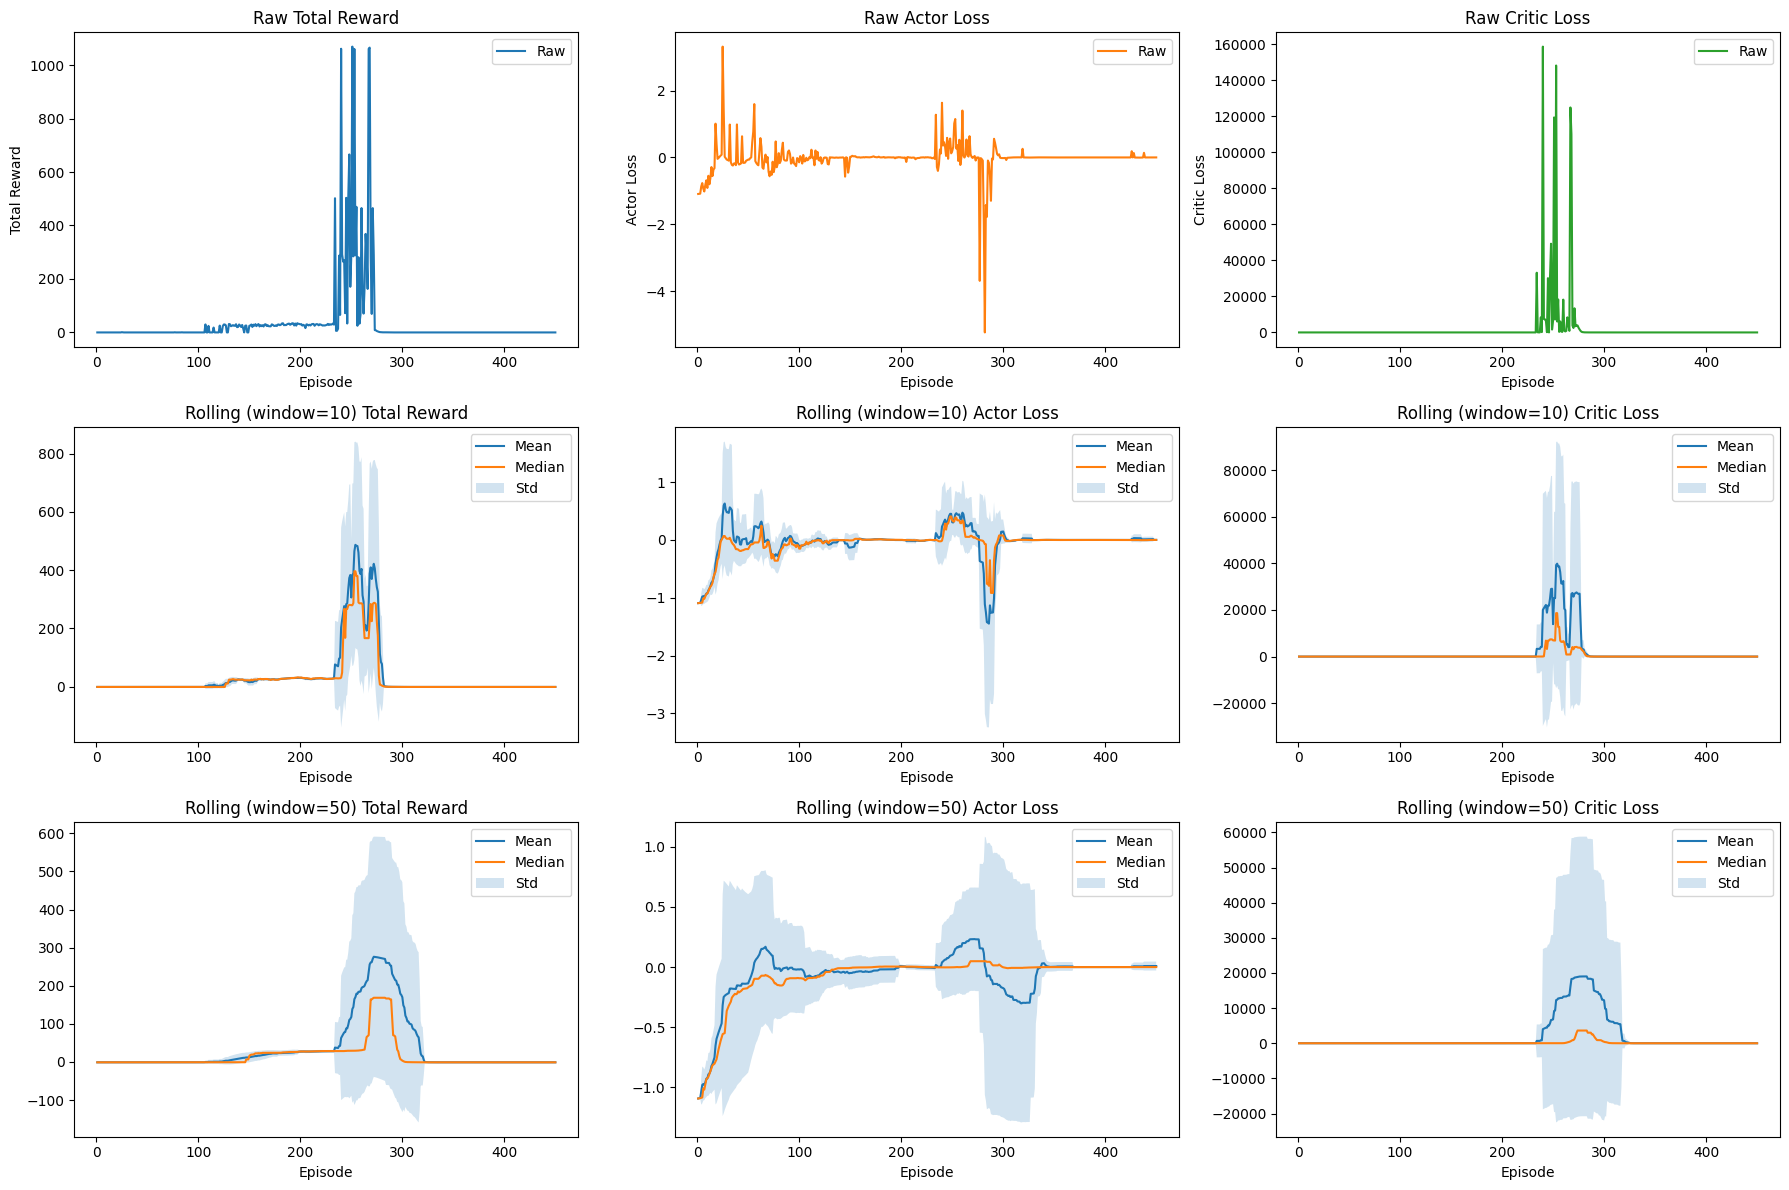

  Metrics plot displayed for Stage 1.
  Generating plot for Stage 2: Stage_2 (300 data points)


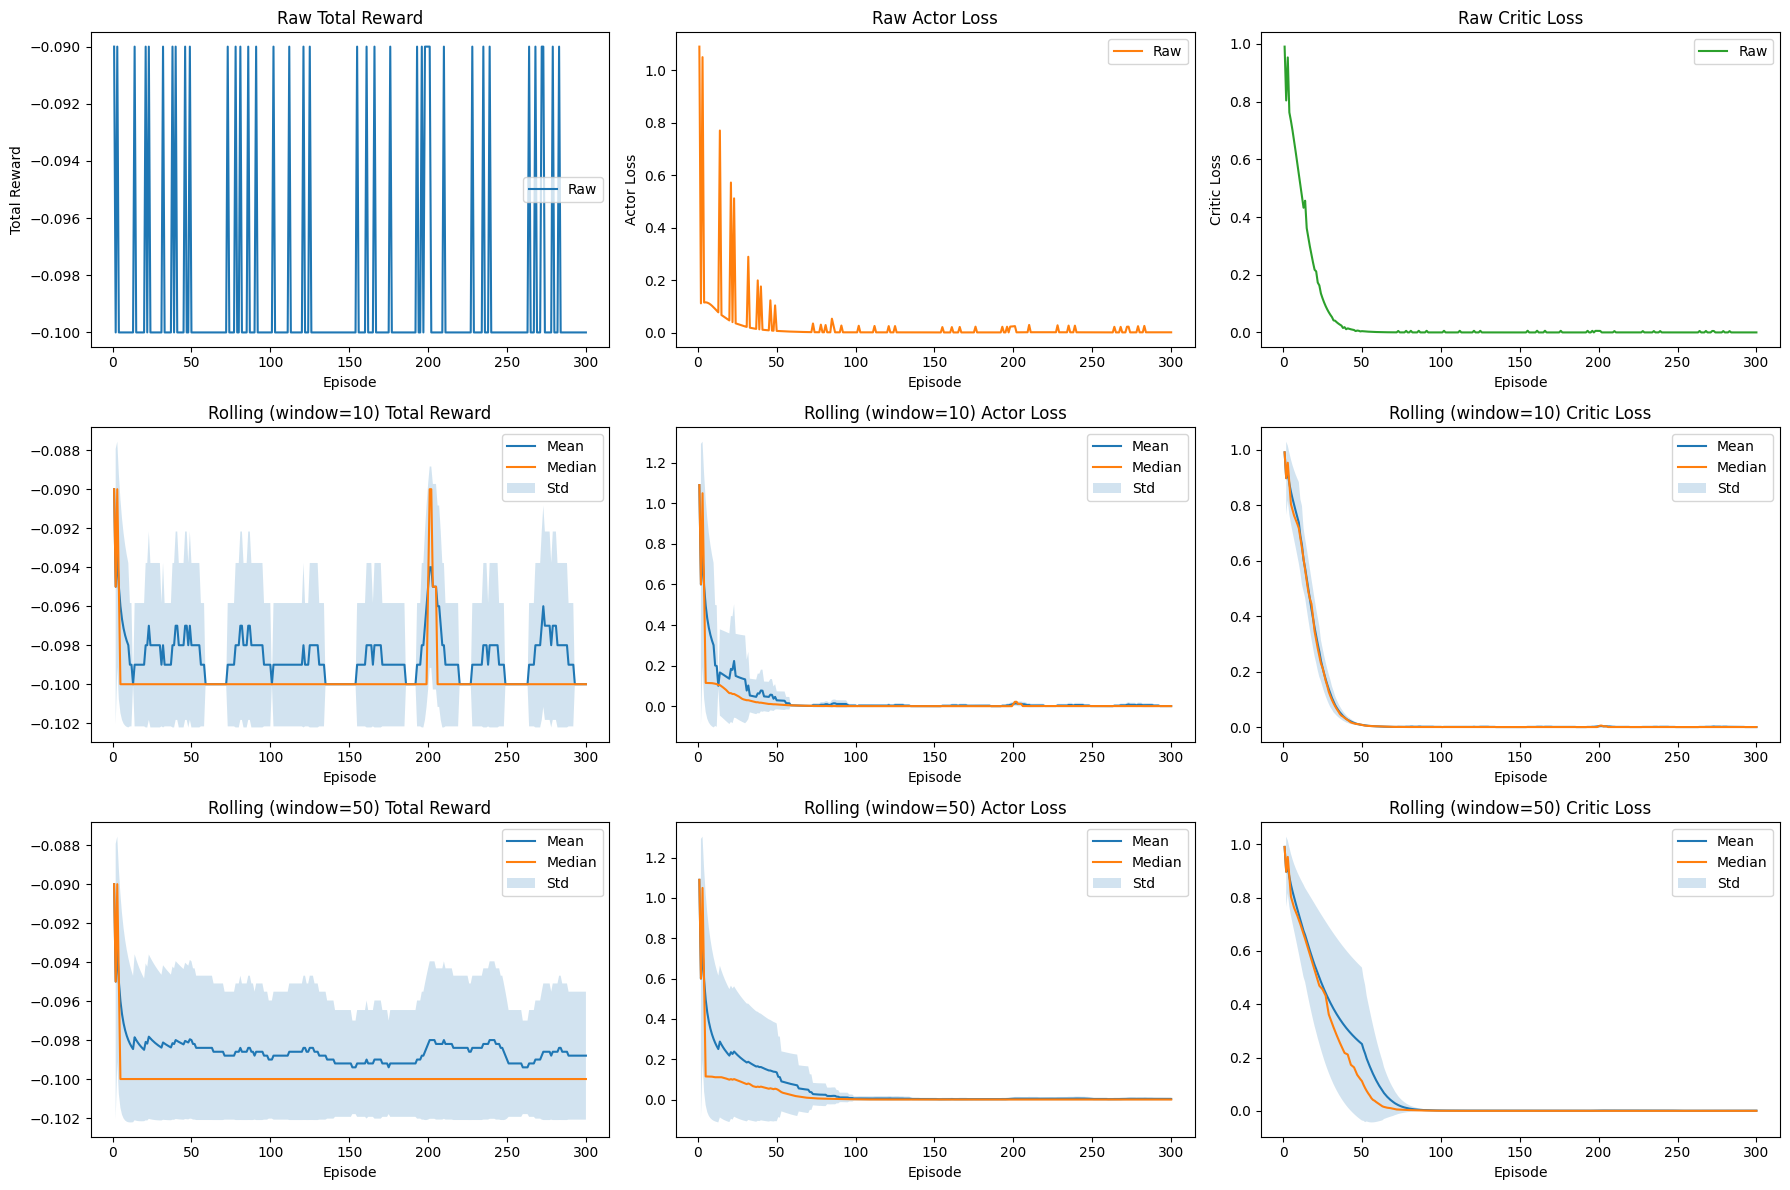

  Metrics plot displayed for Stage 2.
  Generating plot for Stage 3: Stage_3 (300 data points)


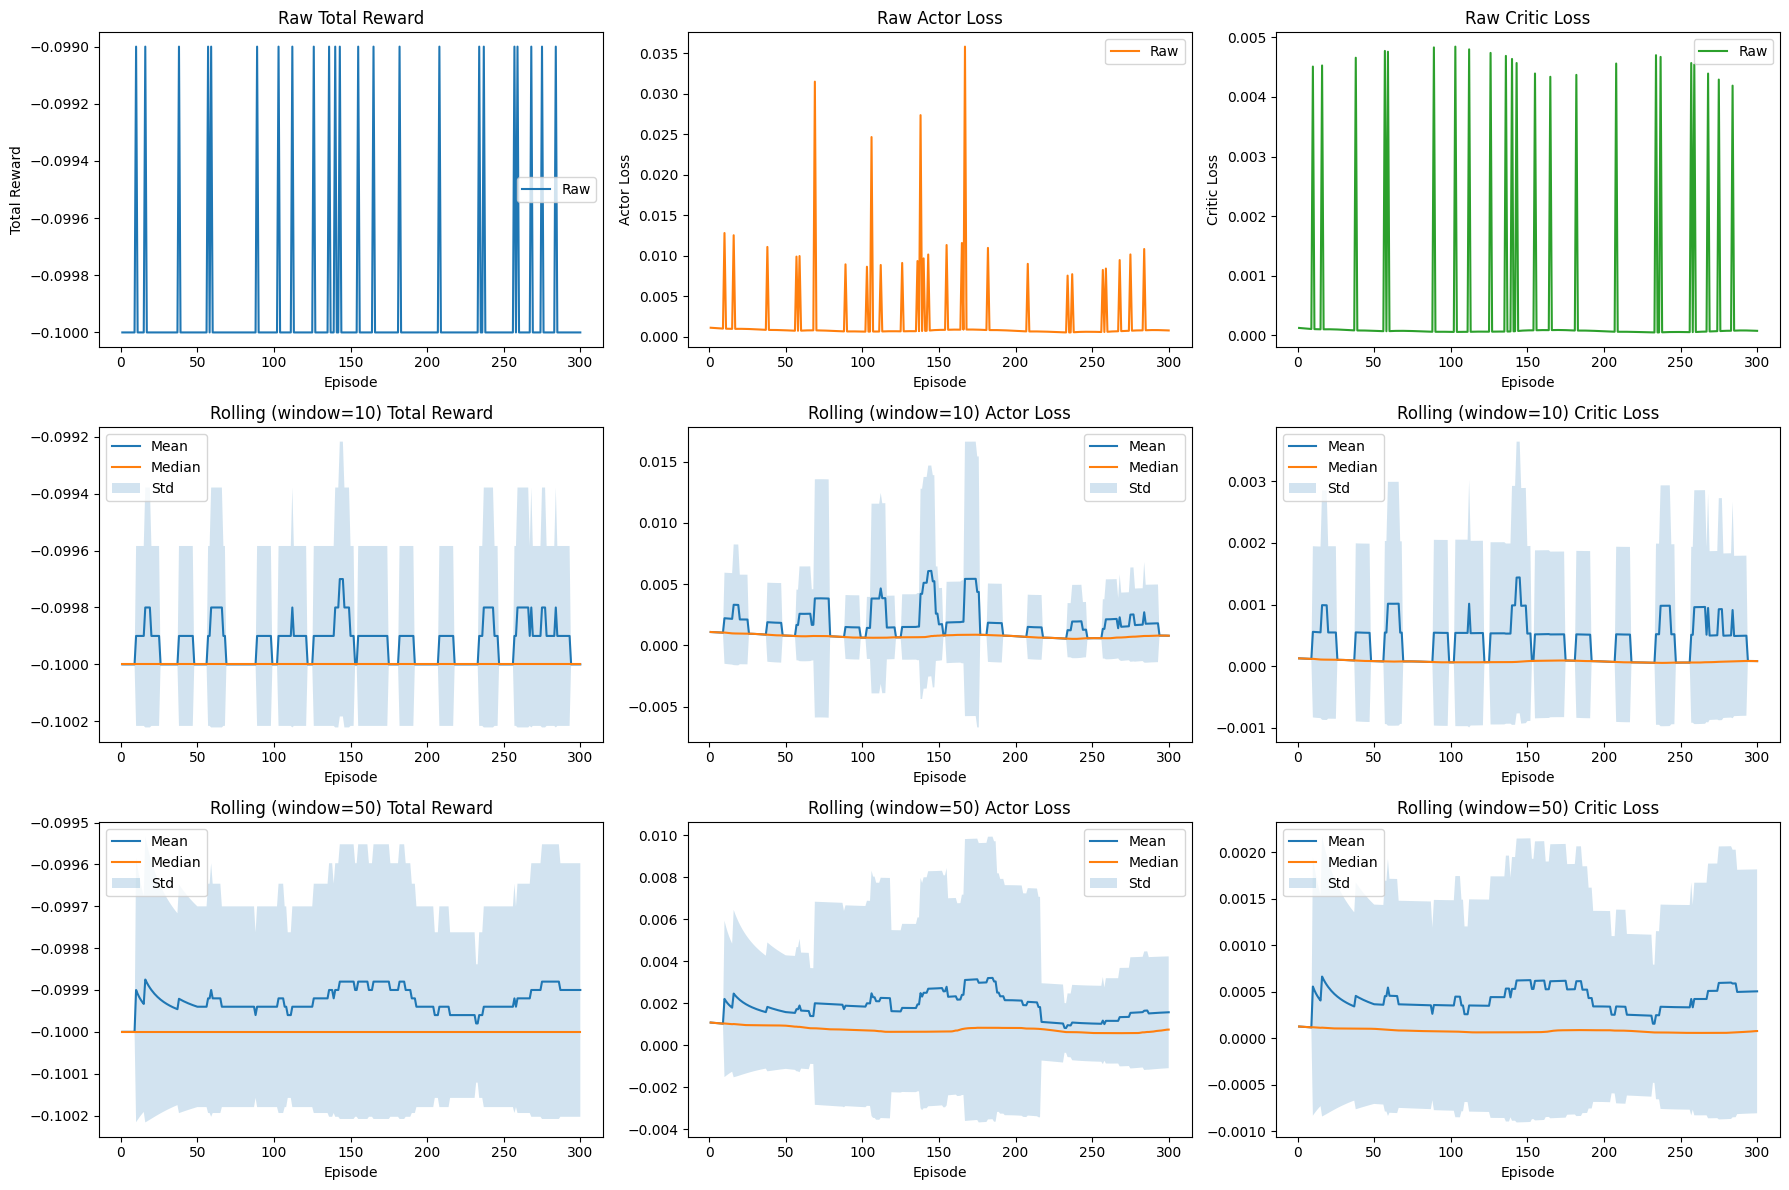

  Metrics plot displayed for Stage 3.
  Generating plot for Stage 4: Stage_4 (500 data points)


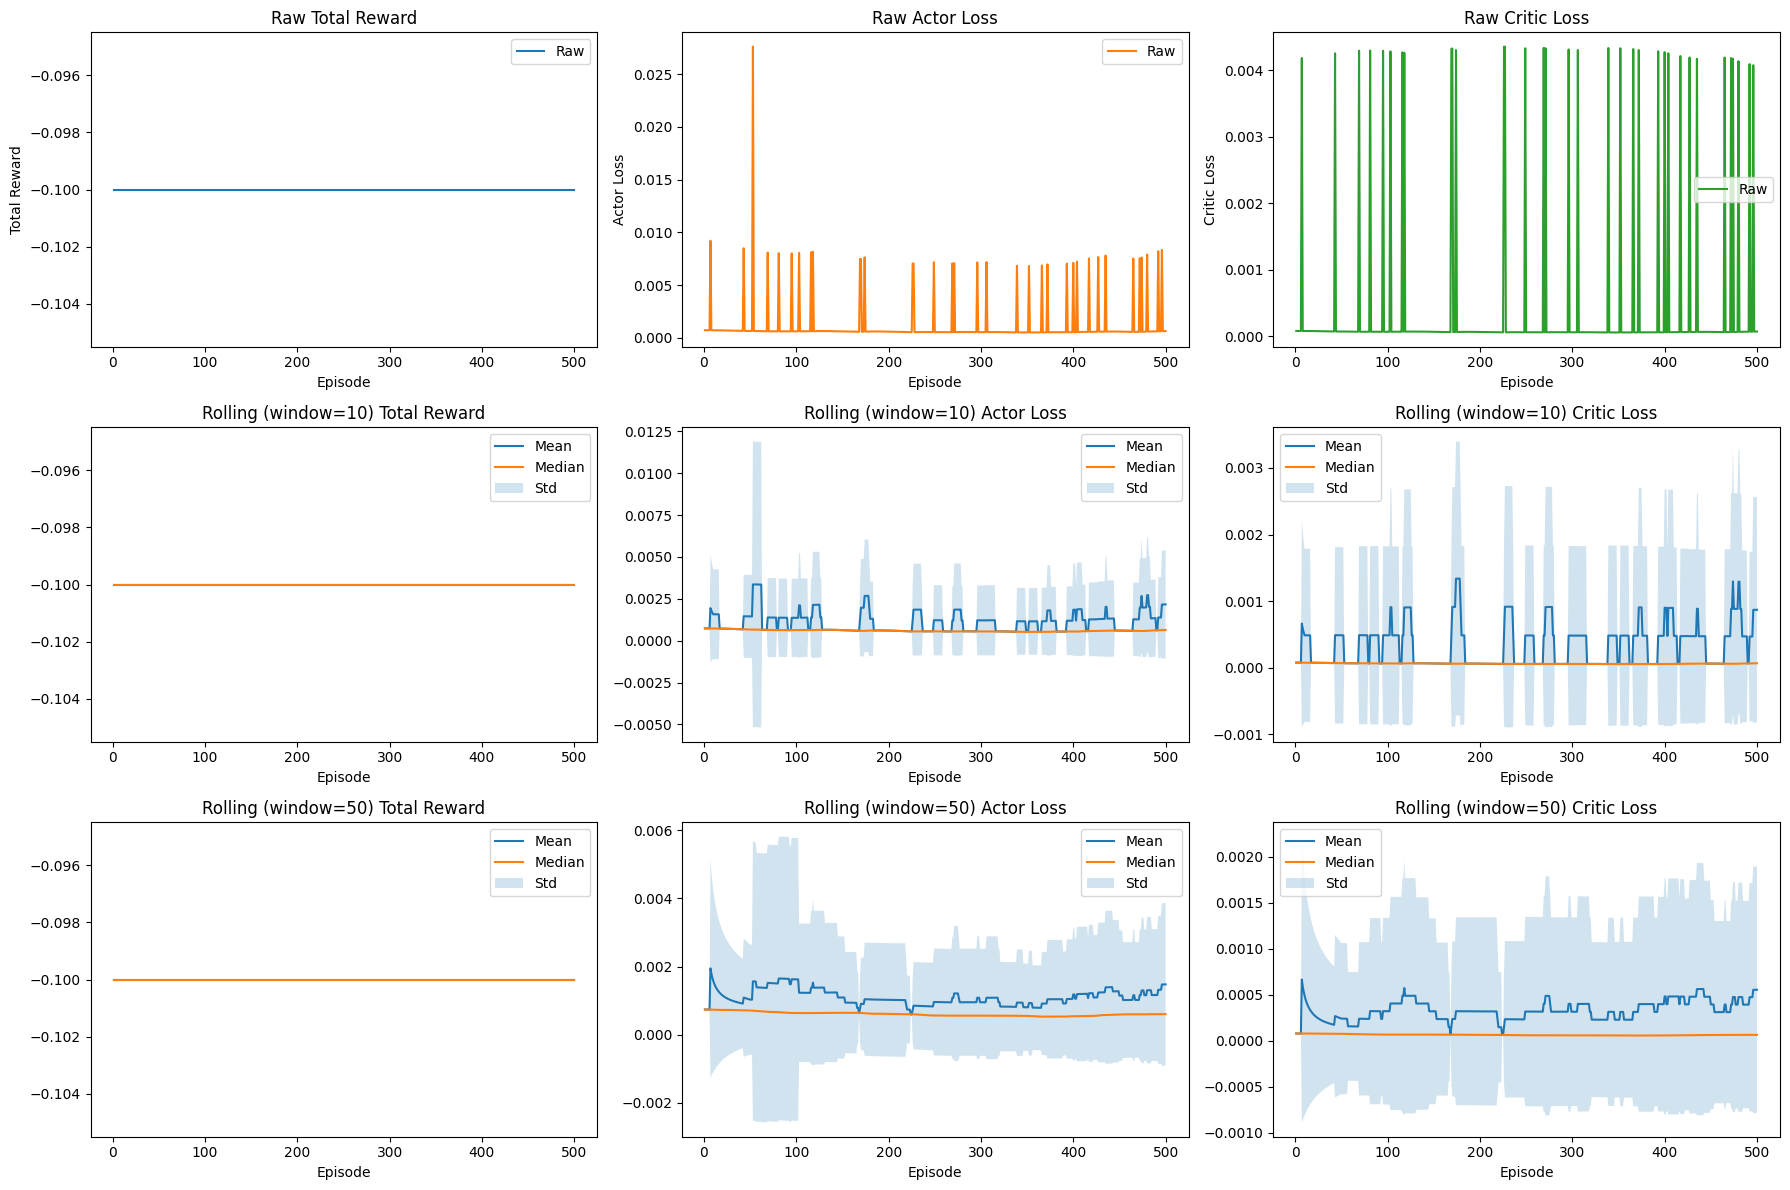

  Metrics plot displayed for Stage 4.

Plotting firing rates...
  Plotting neuron firing rates from the last stage...


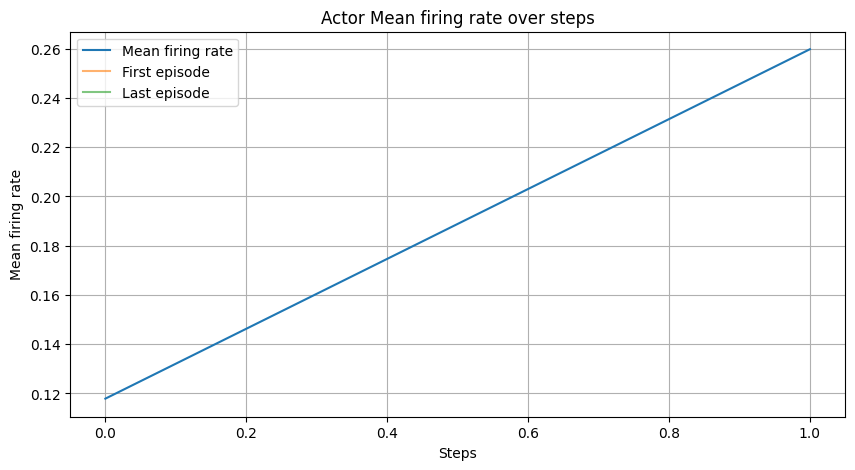

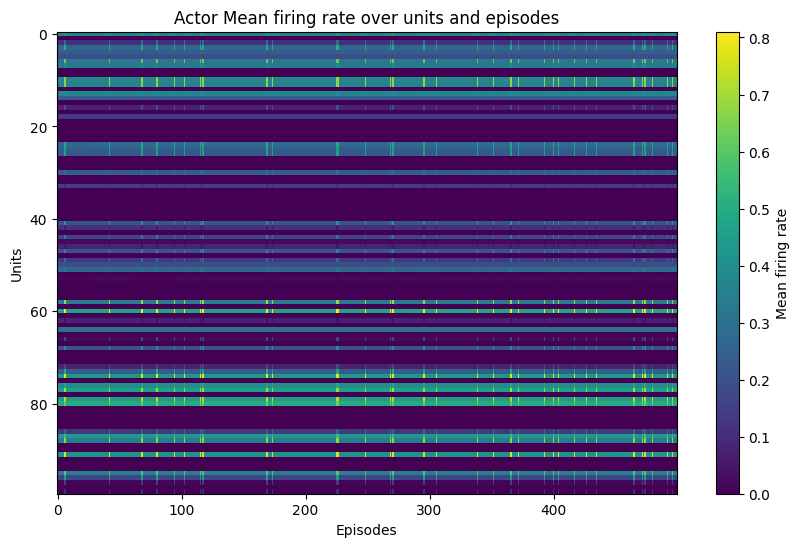

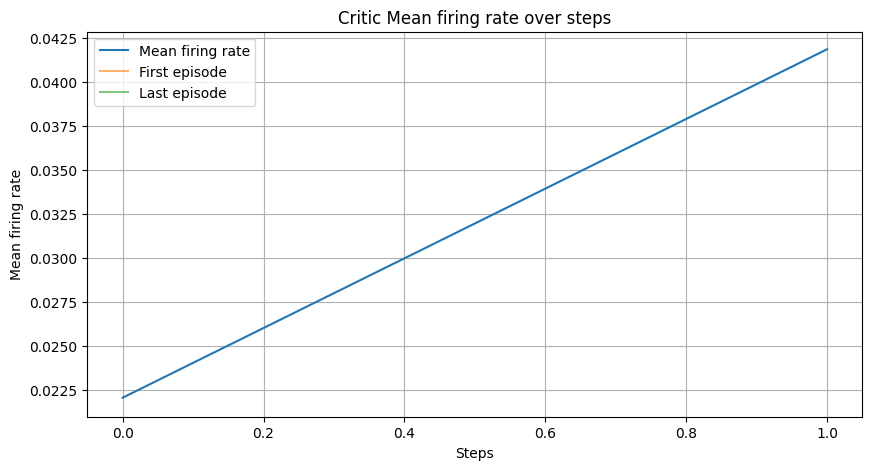

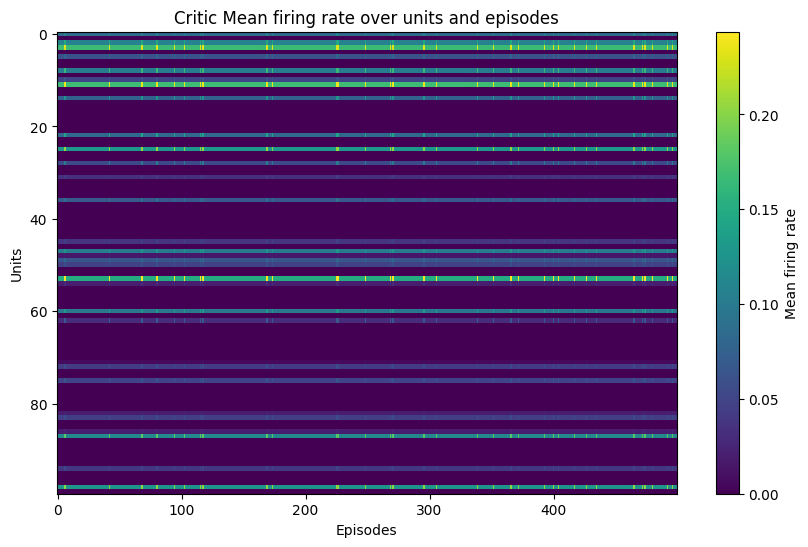

  Firing rate plot displayed.

Script finished.


In [5]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time # To time stages

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))
if module_path not in sys.path: sys.path.append(module_path)
print(f"Module path status checked for: {module_path}")

# --- Import custom modules ---
from env_economic_choice_2 import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Base Configuration ---
base_config = {
    "env_dt_ms": 10,
    "A_to_B_ratio": 2.2,
    "input_noise_sigma": 0.01,
    "gamma": 0.99,
    "l2_actor": 1e-5,
    "l2_critic": 1e-5,

    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "GRU_modified",
    "alpha": 0.1,
    "actor_prob_connection": 1.0,
    "critic_prob_connection": 1.0,

    "print_interval": 20,
    "record_history": 1
}

# --- Define Training Stages ---
training_stages = [
    {
        "stage_name": "Stage_1",
        "num_episodes": 450,
        "actor_lr": 5e-3,
        "critic_lr": 5e-3,
        # --- Env Params for this stage ---
        "reward_B": 100, 
        "abort_penalty": -1.0,
        "reward_fixation": 0.1,
        "reward_go_decision": 0.1,
        "reward_go_fixation": -0.1,
        "reward_choice_hold": 0.5,
        # --- Save/Load ---
        "load_weights_from": None,
        "save_weights_as": "saved_models/stage1_high_shaping"
    },
    {
        "stage_name": "Stage_2",
        "num_episodes": 300,
        "actor_lr": 1e-3,
        "critic_lr": 1e-3,
        # --- Env Params for this stage ---
        "reward_B": 100,
        "abort_penalty": -0.1,
        "reward_fixation": 0.01,
        "reward_go_decision": 0.01,
        "reward_go_fixation": -0.02,
        "reward_choice_hold": 0.05,
        # --- Save/Load ---
        "load_weights_from": "saved_models/stage1_high_shaping",
        "save_weights_as": "saved_models/stage2_medium_shaping"
    },
    {
        "stage_name": "Stage_3",
        "num_episodes": 300,
        "actor_lr": 5e-4,
        "critic_lr": 5e-4,
         # --- Env Params for this stage ---
        "reward_B": 1,
        "abort_penalty": -0.1,
        "reward_fixation": 0.001,
        "reward_go_decision": 0.001,
        "reward_go_fixation": -0.01,
        "reward_choice_hold": 0.01,
        # --- Save/Load ---
        "load_weights_from": "saved_models/stage2_medium_shaping",
        "save_weights_as": "saved_models/stage3_low_shaping"
    },
    {
        "stage_name": "Stage_4",
        "num_episodes": 500,
        "actor_lr": 1e-4,
        "critic_lr": 1e-4,
        # --- Env Params for this stage ---
        "reward_B": 1,
        "abort_penalty": -0.1,
        "reward_fixation": 0.0,
        "reward_go_decision": 0.0,
        "reward_go_fixation": 0.0,
        "reward_choice_hold": 0.0,
        # --- Save/Load ---
        "load_weights_from": "saved_models/stage3_low_shaping",
        "save_weights_as": "saved_models/stage4_final"
    }
]

# --- Ensure save directory exists ---
save_dir = os.path.dirname(training_stages[0]["save_weights_as"])
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")

# --- Agent Setup (Initialize ONCE) ---
print("Initializing Actor-Critic Agent structure...")
temp_env = EconomicChoiceEnv(dt=base_config["env_dt_ms"])
obs_size = temp_env.observation_space.shape[0]
act_size = temp_env.action_space.n
temp_env.close()
print(f"Obs size: {obs_size}, Act size: {act_size}")

agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=base_config["actor_hidden_size"],
    critic_hidden_size=base_config["critic_hidden_size"],
    actor_layers=base_config["actor_layers"],
    critic_layers=base_config["critic_layers"],
    actor_lr=training_stages[0]['actor_lr'],
    critic_lr=training_stages[0]['critic_lr'],
    actor_prob_connection=base_config["actor_prob_connection"],
    critic_prob_connection=base_config["critic_prob_connection"],
    layer_type=base_config["layer_type"],
    alpha=base_config["alpha"]
)
# --- Build models ---
print("Building agent models...")
try:
    dummy_state = np.zeros(obs_size, dtype=np.float32)
    _ = agent.select_action(dummy_state, training=False)
    _ = agent.evaluate_state(dummy_state, training=False)
    print("Agent models built.")
except Exception as e:
    print(f"Warning: Error during dummy model call (build step): {e}")

print("Agent structure initialized.")

# --- Variables to store combined history ---
all_total_rewards = []
all_actor_losses = []
all_critic_losses = []
stage_transitions = [0]
current_total_episodes = 0
last_actor_fr = None
last_critic_fr = None

# --- Training Loop Across Stages ---
total_training_start_time = time.time()
for i, stage_config in enumerate(training_stages):
    stage_start_time = time.time()
    print("\n" + "="*60)
    print(f"  Starting Training Stage {i+1}: {stage_config['stage_name']}  ")
    print("="*60)
    # --- Print Stage Config ---
    print(f"  Episodes: {stage_config['num_episodes']}, ALR={stage_config['actor_lr']:.1e}, CLR={stage_config['critic_lr']:.1e}")
    print(f"  Env Params: RewardB={stage_config['reward_B']}, AbortP={stage_config['abort_penalty']}") # Added Env Params
    print(f"  Step Rewards: Fix={stage_config['reward_fixation']}, GoDec={stage_config['reward_go_decision']}, GoFix={stage_config['reward_go_fixation']}, Hold={stage_config['reward_choice_hold']}")
    print(f"  Load From: {stage_config['load_weights_from']}")
    print(f"  Save To:   {stage_config['save_weights_as']}")
    print("-"*60)

    # 1. Load Weights for the agent (if specified)
    if stage_config['load_weights_from']:
        print(f"  Attempting to load weights from: {stage_config['load_weights_from']}")
        load_successful = agent.load_weights(stage_config['load_weights_from'])
        if not load_successful:
            print(f"  WARNING: Failed to load weights for stage {i+1}. Continuing with current agent weights.")
    else:
        print("  Starting stage 1 from scratch (no weights loaded).")

    # 2. Create Environment with stage-specific parameters
    print("  Creating environment for this stage...")
    env = EconomicChoiceEnv(
        # Base params
        dt=base_config["env_dt_ms"],
        A_to_B_ratio=base_config["A_to_B_ratio"],
        input_noise_sigma=base_config["input_noise_sigma"],
        # Stage-specific params
        reward_B=stage_config["reward_B"],
        abort_penalty=stage_config["abort_penalty"],
        reward_fixation=stage_config["reward_fixation"],
        reward_go_decision=stage_config["reward_go_decision"],
        reward_go_fixation=stage_config["reward_go_fixation"],
        reward_choice_hold=stage_config["reward_choice_hold"]
    )
    env.reset(seed=seed_value + i)

    # 3. Set Agent Optimizer Learning Rates for this stage
    print(f"  Setting optimizer learning rates: Actor={stage_config['actor_lr']:.1e}, Critic={stage_config['critic_lr']:.1e}")
    agent.actor_optimizer.learning_rate.assign(stage_config['actor_lr'])
    agent.critic_optimizer.learning_rate.assign(stage_config['critic_lr'])

    # 4. Train for this stage using train_agent function
    print(f"  Starting training loop for {stage_config['num_episodes']} episodes...")
    stage_rewards, stage_actor_loss, stage_critic_loss, \
    stage_actor_fr, stage_critic_fr = train_agent(
        env=env,
        agent=agent,
        num_episodes=stage_config["num_episodes"],
        gamma=base_config["gamma"],
        print_interval=base_config["print_interval"],
        l2_actor=base_config["l2_actor"],
        l2_critic=base_config["l2_critic"],
        record_history=base_config["record_history"]
    )

    # 5. Append results to overall history
    all_total_rewards.extend(stage_rewards)
    all_actor_losses.extend(stage_actor_loss)
    all_critic_losses.extend(stage_critic_loss)
    current_total_episodes += len(stage_rewards)
    stage_transitions.append(current_total_episodes)
    last_actor_fr = stage_actor_fr
    last_critic_fr = stage_critic_fr

    # 6. Save Agent Weights
    if stage_config['save_weights_as']:
        print(f"  Saving agent weights to: {stage_config['save_weights_as']}")
        agent.save_weights(stage_config['save_weights_as'])

    # 7. Close environment instance for this stage
    env.close()
    print("  Environment closed for this stage.")

    stage_duration = time.time() - stage_start_time
    print(f"--- Stage {i+1} ({stage_config['stage_name']}) finished in {stage_duration:.2f} seconds ---")


print("\n" + "="*60)
print("  All Training Stages Finished.")
total_training_duration = time.time() - total_training_start_time
print(f"  Total training duration: {total_training_duration:.2f} seconds.")
print("="*60 + "\n")


# --- Plot Metrics per Stage ---
print("Plotting metrics per stage...")
num_stages = len(training_stages)
for stage_idx in range(num_stages):
    stage_name = training_stages[stage_idx]["stage_name"]
    # Get start and end indices for slicing the combined history
    start_idx = stage_transitions[stage_idx]
    end_idx = stage_transitions[stage_idx + 1]

    # Slice the data for the current stage
    stage_rewards_data = all_total_rewards[start_idx:end_idx]
    stage_actor_loss_data = all_actor_losses[start_idx:end_idx]
    stage_critic_loss_data = all_critic_losses[start_idx:end_idx]

    if not stage_rewards_data:
        print(f"  Skipping plot for Stage {stage_idx+1} ({stage_name}) - No data recorded (check record_history and num_episodes).")
        continue

    print(f"  Generating plot for Stage {stage_idx+1}: {stage_name} ({len(stage_rewards_data)} data points)")

    try:
        # Determine appropriate window sizes based on number of points in THIS stage
        num_points_in_stage = len(stage_rewards_data)
        window_1 = max(1, min(10, num_points_in_stage // 5))
        window_2 = max(1, min(50, num_points_in_stage // 2))

        # Call plot_metrics for the sliced data
        plot_metrics(
            stage_rewards_data,
            stage_actor_loss_data,
            stage_critic_loss_data,
            window_1=window_1,
            window_2=window_2,
        )
        print(f"  Metrics plot displayed for Stage {stage_idx+1}.")

    except Exception as e:
        print(f"  Error plotting metrics for Stage {stage_idx+1}: {e}")


# --- Plot Firing Rates (e.g., from the last stage) ---
print("\nPlotting firing rates...")
if last_actor_fr is not None and last_critic_fr is not None:
    print("  Plotting neuron firing rates from the last stage...")
    plot_firing_rates(last_actor_fr, last_critic_fr)
    print("  Firing rate plot displayed.")
# ... [rest of firing rate plotting checks] ...
else:
    print("  Firing rate data not available for the last stage.")

print("\nScript finished.")